# Part 0: Libraries (done):

In [1]:
from collections import OrderedDict
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Part I: Functions:

In [26]:
#Function 1: 
def parse_data_item(s):
    """
    INPUT: s (string; description of data value)
    OUTPUT: attributes (set of strings; sub-domain/yield-type/season-harvested etc.) \
        unit (string; ex. BU/net harvested acre) 
    OVERVIEW: Parse String in column "Data Item": 
    """
    left, unit = s.split(" - YIELD, MEASURED IN ")
    attributes = set(left.split(", ")[1:])
    master_attributes.update(attributes)
    return attributes, unit

#Function 2: 
def add_columns(df, s):
    """
    INPUT: df (data frame), s (set of strings of column names )
    OUTPUT: N/A
    OVERVIEW: Add new columns to dataframe: 
    """
    for name in s:
        df[name] = df["Crop Attributes"].apply(lambda x: 1 if (name in x) else 0) 
        
#Function 3: 
def count_irrigation(df, time_period):
    """
    INPUT: df (data frame), time_period (string; the time period this calculation is based on)
    OUTPUT: N/A
    OVERVIEW: count/print of irrigated vs. non-irrigated crops: 
    """
    irrigated = len(df[df["IRRIGATED"]==1])
    non_irrigated = len(df[df["NON-IRRIGATED"]==0])
    print "__Time period:{}__".format(time_period)
    print "Total irrigated crops: {}".format(irrigated)
    print "Total non-irrigated crops: {}".format(non_irrigated)
    print "Ratio of irrigated/non-irrigated: {}".format(irrigated/float(non_irrigated))
    
#Function 4: 
def count_sub_type(df, time_period): 
    """
    INPUT: df (data frame), time_period (string; the time period this calculation is based on) 
    OUTPUT: count (# of total sub_types of all commodities in this data frame)
    OVERVIEW: count/print total sub_type of master commodity during a period: 
    """
    df = df[df["year"]==time_period]
    all_commodities = df["commodity_desc"].unique()
    total_commodities, total_sub_domains = len(all_commodities), 0
    print "__Time period:{}__".format(time_period)
    for commodity in all_commodities:
        sub_domains_count = len(df[df["commodity_desc"]==commodity])
        total_sub_domains += sub_domains_count
        print "{} has {} sub_types".format(commodity, sub_domains_count)
    print "Total general commodities: {}".format(total_commodities)
    print "Total commodities: {}".format(total_sub_domains)
    
#Function 5: 
def graph_yield(df, year, comparing_variable):
    """
    INPUT: df (data frame), commodity (string; type of commodity one wishes to graph);\
        comparing_variable (string; type of variable one wishes to compare)
    OUTPUT: N/A
    OVERVIEW: graphing the sum of one general type of cmmodity against a comparing_variable
    """
    #i.grabbing values: 
    df = df[df["year"]==year]
    year_commodities = df["commodity_desc"].unique()
    for commodity in year_commodities:
        df_commodity = df[df["commodity_desc"]==commodity]
        filtered_df = df_commodity.groupby(by=[comparing_variable])["value"].mean()
        comparing_variable_list, yield_per_acre = list(filtered_df.index), list(filtered_df.values)
        if len(set(df_commodity["unit_desc"].values)) == 1:
            unit = df_commodity["unit_desc"].values[0]
        else:
            print "ERROR: MULTIPLE TYPES OF UNIT FOR COMMODITY"
            print "DETAILS ABOUT ERROR:"
            print commodity
            print set(df["unit_desc"].values)
            return None 
        #ii. graph:
        graph_bar(comparing_variable_list, yield_per_acre, comparing_variable, unit, commodity, year)

#Function 6:
def convert_unit(x, conversion_dict):
    """
    INPUT: x (row of dataframe); conversion_dict (dict; unit conversion (key = "commodity; value = conversion rate))
    OUPUT: new_val (float)
    OVERVIEW: N/A
    """
    new_val = x['value']
    if "BU" in x['unit_desc']:
        new_val = round(new_val*conversion_dict[x['commodity_desc']],2)
    return new_val

#Function 7:
def change_unit_name(x):
    """
    INPUT: x (row of dataframe)
    OUPUT: new_name (str)
    OVERVIEW: N/A
    """
    new_name = x['unit_desc']
    if "BU" in x['unit_desc']:
        new_name = x['unit_desc'].replace('BU', 'TONS')
    return new_name 
    
#Function 8:
def standardrize_unit(df, conversion_dict):
    """
    INPUT: df(data frame), conversion_dict (dict; unit conversion (key = "commodity; value = conversion rate))
    OUTPUT: df(data frame)
    OVERVIEW: standardrize data frame unit to ton/area
    """
    df['value'] = df.apply(convert_unit,axis=1, args = (conversion_dict,))
    df['unit_desc'] = df.apply(change_unit_name,axis=1)
    return df 

#Function 9:
def graph_bar(x, y, x_label, y_label, title, year):
    """
    INPUT: x (list of str of discrete variables), y (list of float values)\
        ,x_label (str of discrete variable types), y_label (float of y-axis unit)\
        ,title (str; title of graph), year (int)
    OUTPUT: N/A
    OVERVIEW: N/A
    """
    with plt.style.context('fivethirtyeight'):
        len_x = range(len(x))
        plt.bar(len_x, y, align='center')
        plt.xticks(len_x, x, rotation='vertical')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title+" ({})".format(year))
        plt.show()
        
#Function 10:
def find_BU_commdity(df):
    """
    INPUT: df (dataframe)
    OUTPUT: BU_commidty (list of unique commodity that uses BU as unit)
    """    
    return list(df[df['unit_desc'].apply(lambda x: True if 'BU' in x else False)]['commodity_desc'].unique())

# Part II: Load/Clean Data: 

In [ ]:
#1. Descriptions of yield data:

#Respective aggregated annual field crops yields on county level (U.S.) from 1970 to 2014. For this project, we will be\
#focusing on the 10 top agriculture states, interms of total agricultural economic output, which are responsible for 50%\
#of the total U.S. agricultural economic activities. This data was collected via USDA annual agriculture survey.
#Link: http://innovationchallenge.azurewebsites.net/#NassTab

In [4]:
#2: Declaring Variables:

start_year, end_year = 1970, 2014
master_attributes = set()
missing_yield_years = [1982, 1984, 1985]
#Targeting 10 top agriculture states (based on economic output)
#Source: http://www.ers.usda.gov/faqs.aspx (top 10 agriculture states)
targest_states = ["California", "Iowa", "Texas", "Nebraska", "Illinois",\
                  "Minnesota", "Kansas", "Indiana", "North Carolina", "Wisconsin"]
#dataframe to hold all info: 
#yield_master_df = pd.DataFrame()
targest_states = [state.upper() for state in targest_states]

In [ ]:
#3: Load csv files and combine them into master dataframe:  

#for year in xrange(start_year, end_year+1):
#    if year not in missing_yield_years:
#        year_df = pd.read_csv("/Users/Hsieh/Desktop/persephone/Data/Yield/yield_{}.csv".format(year))
#        yield_master_df = yield_master_df.append([year_df])

In [ ]:
#4: reordering master_df:
#yield_master_df.sort("year", ascending=True, inplace=True)
#yield_master_df.reset_index(inplace=True)
#back up copy:
#master_df_copy = master_df.copy()
#yield_master_df.to_csv('/Users/Hsieh/Desktop/persephone/Data/raw_master_yield.csv')
#yield_master_df = pd.read_csv('/Users/Hsieh/Desktop/persephone/Data/raw_master_yield.csv')

In [ ]:
#3: Refine dataframe: 

#i: declare list of columns type:
excess_columns = ['index', 'Unnamed: 0', 'CV', 'agg_level_desc','begin_code', 'country_code','country_name','domain_desc',\
                  'domaincat_desc','end_code','freq_desc','group_desc','load_time','reference_period_desc','reference_period_desc',\
                  'region_desc','sector_desc','source_desc','state_ansi','state_fips_code','state_alpha','watershed_code','watershed_desc',\
                  'zip_5']
key_columns = ['commodity_desc','county_name','data_item','state_alpha','state_name','statisticcat_desc',
               'unit_desc','value','year']
other_columns = ['asd_code','asd_desc','class_desc','congr_district_code','location_desc','prodn_practice_desc',\
                 'util_practice_desc','county_ansi',\
                'county_code']
                  
#ii: notes on columns:       
#a): other column name notes: 
#asd_code: NASS defined county groups, unique within a state,2-digit ag statistics district code
#asd_desc: Ag statistics district name
#class_desc: Generally a physical attribute (e.g., variety, size, color, gender) of the commodity.
#congr_district_code: US Congressional District 2-digit code.       
#location_desc: full description for the location dimension.   
#prodn_practice_desc: A method of production or action taken on the commodity (e.g., IRRIGATED, ORGANIC, ON FEED)
#util_practice_desc: Utilizations (e.g., GRAIN, FROZEN, SLAUGHTER)or marketing channels (e.g., FRESH MARKET,PROCESSING, RETAIL).

#b): key column name notes"
#commodity_desc: The primary subject of interest (e.g., CORN, CATTLE, LABOR, TRACTORS, OPERATORS).
#data_item: A concatenation of six columns: commodity_desc,class_desc, prodn_practice_desc, util_practice_desc,statisticcat_desc, and unit_desc.
#state_alpha: State abbreviation, 2-character alpha code
#statisticcat_desc: The aspect of a commodity being measured (e.g., AREA HARVESTED, PRICE RECEIVED, INVENTORY, SALES).
#unit_desc: The unit associated with the statistic category (e.g.ACRES, $ / LB, HEAD, $, OPERATIONS).
#value: Published data value or suppression reason code.
#year: The numeric year of the data

In [ ]:
#3: Refine dataframe: 
#a) filter out unnecessary columns:
yield_model_df = yield_master_df.filter(key_columns+other_columns,axis=1)
#b)  filter unnecessary values:
yield_model_df = yield_model_df[yield_model_df['county_name']!='OTHER (COMBINED) COUNTIES']

In [ ]:
#4: convert values in column "Unit" to float:
yield_model_df["value"] = yield_model_df["value"].apply(lambda x: float(x.replace(",","")))

# Part III: EDA: 

## a) Overview: 

In [ ]:
#1: original column names:
yield_model_df.columns

In [ ]:
#4: general commodity types:
yield_model_df["commodity_desc"].unique()

In [ ]:
#5: pre/post 1990:
#a: pre 1990:
pre1990_yield_df = yield_model_df[yield_model_df["year"]<=1989]
#b: post 1990:
post1990_yield_df = yield_model_df[yield_model_df["year"]>1989]

In [ ]:
#6: count of net acre harvested v.s. count of acre harvested:
print "PRE-1990:"
print pre1990_yield_df["unit_desc"].value_counts()
#b: post 1990:
print "POST-1989"
print post1990_yield_df["unit_desc"].value_counts()
#c: conclusion: 
#i. after 1989, almost only unit/acre data avaliable 
#ii. before 1989 (1989 included): about 50/50

In [ ]:
#8: total # crop types over the years (out put every 10 year mark):
for year in xrange(1970, 2020, 5):
    count_sub_type(yield_model_df, year)
    print "************************"

In [ ]:
#9: find all commodity that uses BU as measurement: 
BU_commodity = find_BU_commdity(yield_master_df)

In [ ]:
print BU_commodity

# Part IV: Feature Engineering:

In [ ]:
#1: creating conversion rates for diff units (for crops measured in bu)
#resources: 
#https://www.agric.gov.ab.ca/app19/calc/crop/bushel2tonne.jsp
#http://www.grains.org/buyingselling/conversion-factors

tonne_per_ton = 0.907185
#tonne_per_bu for each commodities: 
tonne_bu_dict = OrderedDict({"CORN":0.25, "BARLEY": 0.021, "WHEAT":0.027, "SORGHUM":0.25, "OATS":0.015, 'RYE':0.025,\
                            "SOYBEANS":0.027,"FLAXSEED":0.025})
#ton_per_bu for each commodities:
ton_bu_dict = {}
for commodity in tonne_bu_dict:
    ton_bu_dict[commodity] = tonne_bu_dict[commodity]/tonne_per_ton

In [ ]:
print ton_bu_dict

In [ ]:
#2: standardized df unit to 'TONS / ACRE':
yield_model_df = standardrize_unit(yield_model_df, ton_bu_dict)

In [ ]:
#3: write cleaned yield data to csv: 
#yield_model_df.to_csv('/Users/Hsieh/Desktop/persephone/Data/cleaned_master_yield.csv')
#yield_model_df = pd.read_csv('/Users/Hsieh/Desktop/persephone/Data/cleaned_master_yield.csv')

In [5]:
#4: filtering out df with 10 target states and write them into new csv file: 
#yield_model_df = yield_model_df[yield_model_df['state_name'].apply(lambda x: True if (x in targest_states) else False)]
#yield_model_df.to_csv('/Users/Hsieh/Desktop/persephone/Data/target_states_yield.csv')
yield_model_df = pd.read_csv('/Users/Hsieh/Desktop/persephone/Data/target_states_yield.csv')

In [14]:
yield_model_df['unit_desc'].unique()

array(['TONS / ACRE', 'TONS', 'ACRES', '480 LB BALES', 'LB / ACRE', 'LB',
       'CWT', 'TONS / NET PLANTED ACRE', 'LB / NET PLANTED ACRE', 'PCT',
       'TONS, DRY BASIS', 'TONS / ACRE, DRY BASIS'], dtype=object)

In [15]:
#filter out the unit we are looking for (yield/acre): 
target_units = ['TONS / ACRE', 'LB / ACRE']
target_model_df = yield_model_df[yield_model_df['unit_desc'].apply(lambda x: True if x in target_units else False)]

## c) Graphs (for each crop types) (w/ 2014):

In [27]:
year = 2011

In [30]:
len(target_model_df['commodity_desc'].unique())

18

## i: Bar Graphs: "yield/acre" v.s. "counties" 

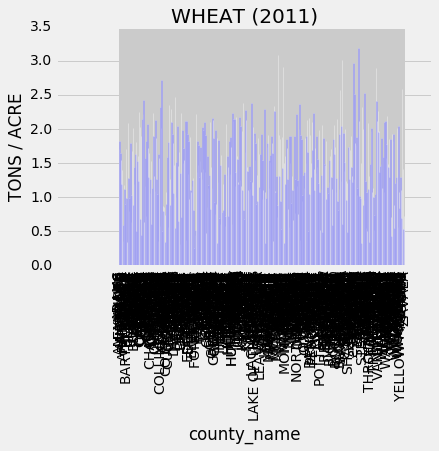

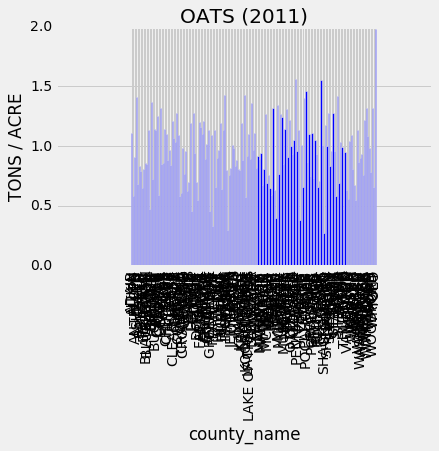

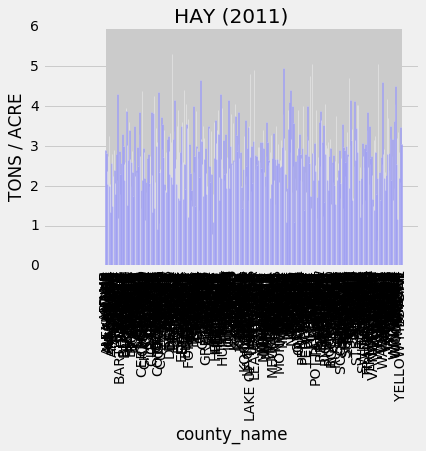

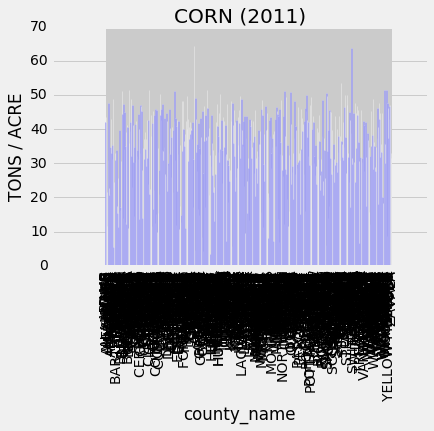

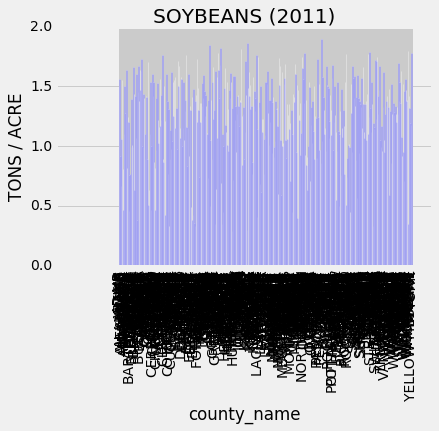

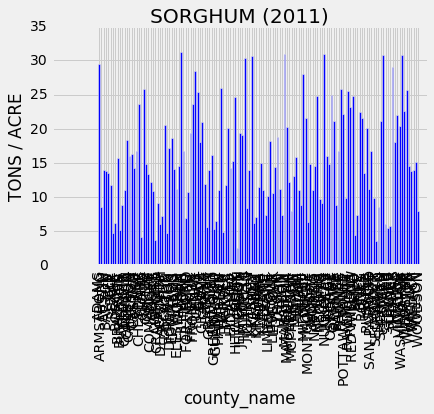

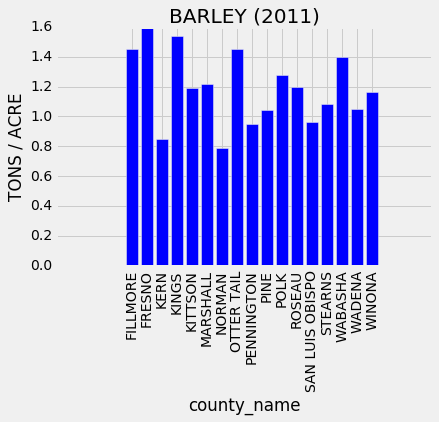

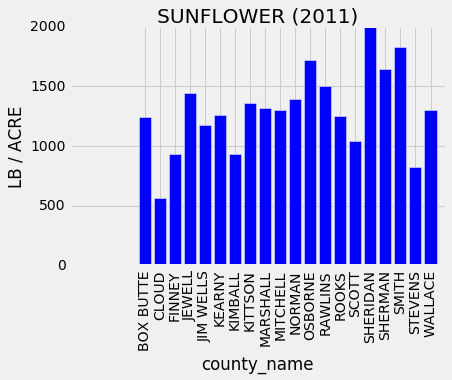

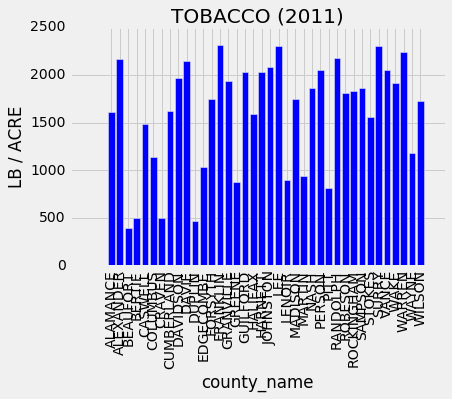

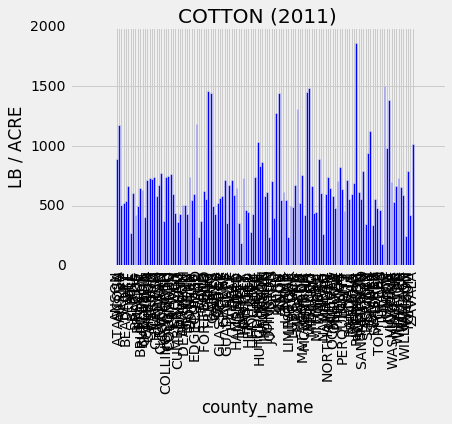

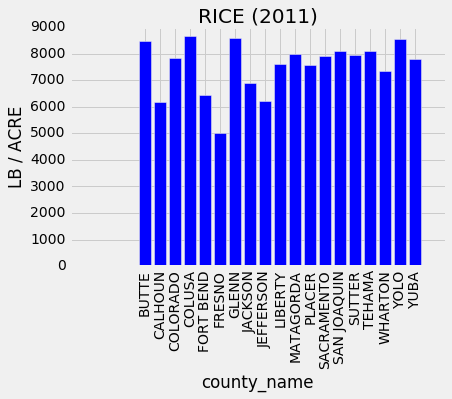

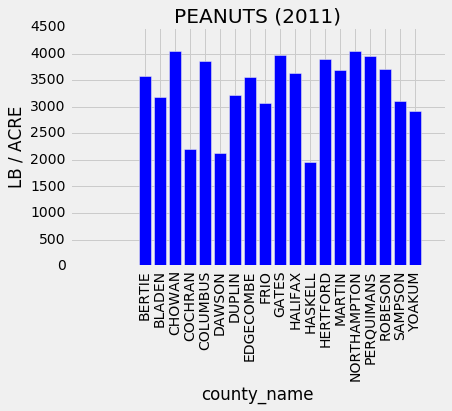

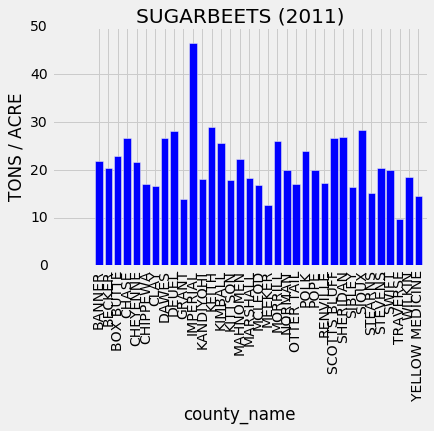

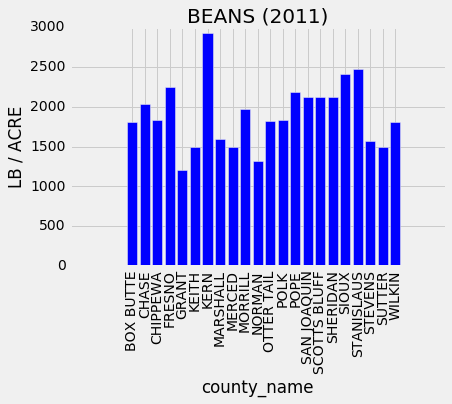

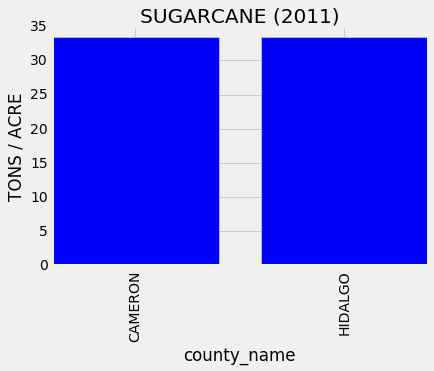

In [28]:
graph_yield(target_model_df, year, 'county_name')

# Part V: Archive Code:

In [ ]:
#1: 

#a) Handpick column names that specifies the type of crop (commodity): 
#NOTED: only beans have "DRY EDIBLE", 
#sub_domain = ["DURUM","GRAIN","SMALL","UPLAND","LIMA","WHITE","KIDNEY","SILAGE","CHICKPEAS"]

#b): Add these sub_domain name to "Commodity" name: 
#add_sub_domain(master_df, sub_domain)
#Function 3: Add sub_domain name to "Commodity" name, then remove the sub_domain names from columns:
"""
def add_sub_domain(df, l):
    #INPUT: df (data frame), l (list of sub_domain names )
    #OUTPUT: N/A
    #OVERVIEW: FILL IN 
    for name in l:
        if df.ix[:, name] == 1:
"""

#2: 

#Pivot data frame so it is right for time series: 
#this line has the basic features:
#index_list = ["County","Commodity","Unit",\
#this line has the season harvested:
#              "SPRING","FOLLOWING SUMMER FALLOW","WINTER","CONTINUOUS CROP",\
#this line has the type of famring techniques used: 
#              "IRRIGATED","NON-IRRIGATED",\
#this line has the sub_domains:
#              "DURUM","GRAIN","SMALL","UPLAND","LIMA","WHITE",\
#              "KIDNEY","SILAGE","RED","PIMA","CHICKPEAS",\
#this line has the usage types:
#              "OIL TYPE","NON-OIL TYPE"]

#p_model_df = pd.pivot_table(model_df, values="Value", index=index_list, columns=["Year"])

#3: 

#refining dataframe with original format csv requested format: 
#a) filter unnecessary values:
#master_df = master_df[master_df['Domain']=='TOTAL']
#master_df = master_df[master_df['Period']=='YEAR']
#master_df = master_df[master_df["County"]!='OTHER (COMBINED) COUNTIES']
#b) drop unnecessary columns:
#master_df.drop(['Program', 'Week Ending','Geo Level', 'State', 'State ANSI','Ag District Code','County ANSI' \
#                ,'Zip Code','Region', 'watershed_code','Watershed', 'Domain', 'Domain Category', 'CV (%)','Period'\
#                ,'index','Ag District'
#               ], axis=1, inplace=True)

#!4:
#Add attributes in "Crop Attributes" as dummy variables: 
#add_columns(master_df, master_attributes)

#5: "Data Item" values: 
#master_df['Data Item'].unique()

#6: make df for model: 
#drop unnecessary columns: 
#archive_columns = ["Data Item","Crop Attributes","PROCESSING","DRY EDIBLE","OTHER","IN THE OPEN"]
#model_df = master_df.drop(archive_columns, axis=1, inplace=False)

#7: model column names:
#model_df.columns

#8: cout irrigated vs non-rrigated vs n/a:
#a) all time: 
#count_irrigation(yield_model_df, "all time")
#b) pre-1900:
#count_irrigation(pre1990_yield_df, "pre 1900")
#c) post-1900:
#count_irrigation(post1990_yield_df, "post 1900")
#d) conclusion: 
#ratio about constant over the years (3 times more non-irrigated crops than irrigated crops )

#9: change unit name function old code:
#if x['unit_desc'].split(' / ')[0] == "BU":
#new_name = "TONS"+' / '+x['unit_desc'].split(' / ')[1]
#return new_name

In [33]:
target_model_df["state_alpha"].unique()

array(['NC', 'NE', 'TX', 'MN', 'IN', 'WI', 'IA', 'KS', 'IL', 'CA'], dtype=object)